# COVID-19 Tweet Sentiment Analysis

The goal of this project is to classify tweets about COVID-19 into positive sentiment and negative emotion. Thsi project also serves to make myself more familiar with state-of-the-art NLP models. 

## Import the data

In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 500)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

from datetime import datetime, timedelta
import time

import string
import re

import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
if torch.cuda.is_available():    
    device = torch.device('cuda')    
else:
    device = torch.device('cpu')

The data for this project comes from Kaggle ([COVID-19 NLP Text Classification](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)) and contains approx. 45,000 tweets concerning COVID-19. 

In [3]:
train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

As we can see, the data includes the Twitter username, their location, the date the tweet was posted, the text of the tweet and the corresponding label (extremely negative, negative, neutral, positive, extremely positive)

In [5]:
train.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

## Preprocessing

Since I do not want the project to be too complex, I decide to only work with the text data and omit the rest of the columns.

In [6]:
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]

To further simply the task at hand, I decide to turn the problem from a multiclass classification problem into a binary classification problem. As such, I drop the tweets labeled as neutral and merge the classes 'Positive' and 'Extremely Positive', and 'Negative' and 'Extremely Negative'.

I do acknowledge that dropping all neutral tweets could turn out to be slightly problematic if the model was to be actually implemented somewhere, since it would definitely encounter neutral tweets but be forced to classify them as either positive or negative. However, since I do this project mainly in order to get more familiar with various different NLP models, simplifying the data is acceptable to me.

In [7]:
train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

For the model to be able to process the labels, I turn them into numerical labels (0 for negative, 1 for positive).

In [8]:
label2idx = {'Extremely Negative': 0, 
            'Negative': 0,
            'Positive': 1,
            'Extremely Positive': 1}

train['Sentiment'] = train['Sentiment'].replace(label2idx)
test['Sentiment'] = test['Sentiment'].replace(label2idx)

In [9]:
train.head()

,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,1
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",1
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",1
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",0
5,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",1


## Tokenization and Building the Dataset and Dataloader

In order to feed the data to my model, I build a simple dataset class that I then use to tokenize the tweets. For this, I import the BERT tokenizer with the the transformers library. This tokenizer is specifically built for the BERT model.

In oder to give a reasonable parameter value for `max_length` (which defines the maximum number of tokens in a sequence, I first tokenize all tweets. I then have a look at the distribution of tweet lengths and take the length corresponding to the 99th percentile (which turn out to be 100 tokens).

In [10]:
class TweetDataset_fortokenization(Dataset):
    
    def __init__(self, text, labels):
        self.text = text.values
        self.labels = labels.values
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        return (self.text[idx], self.labels[idx])

In [11]:
train_ds = TweetDataset_fortokenization(train['OriginalTweet'], train['Sentiment'])
test_ds = TweetDataset_fortokenization(test['OriginalTweet'], test['Sentiment'])

In [12]:
len(train_ds), len(test_ds)

(33444, 3179)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [14]:
example = train_ds.text[10]
print(example)
print(tokenizer.tokenize(example))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example)))




Amazon: https://t.co/8YWaKFjExC
['me', ':', 'i', 'don', "'", 't', 'need', 'to', 'stock', 'up', 'on', 'food', ',', 'i', "'", 'll', 'just', 'have', 'amazon', 'deliver', 'whatever', 'i', 'need', '#', 'corona', '##virus', 'amazon', ':', 'https', ':', '/', '/', 't', '.', 'co', '/', '8', '##y', '##wa', '##k', '##f', '##je', '##x', '##c']
[2033, 1024, 1045, 2123, 1005, 1056, 2342, 2000, 4518, 2039, 2006, 2833, 1010, 1045, 1005, 2222, 2074, 2031, 9733, 8116, 3649, 1045, 2342, 1001, 21887, 23350, 9733, 1024, 16770, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1022, 2100, 4213, 2243, 2546, 6460, 2595, 2278]


In [15]:
all_lengths = []
for tweet in range(len(train_ds)):
    input_ids = tokenizer.encode(train_ds[tweet][0], add_special_tokens=True)
    all_lengths.append(len(input_ids))

In [16]:
print(np.percentile(all_lengths, [75, 90, 99]), max(all_lengths))

[ 69.  81. 100.] 209


I now use max_length to build a tokenizer that truncates each tweet to `max_length` and adds padding accordingly.

In [17]:
def tokenize_map(tweets, lab=False):
    
    input_ids = []
    attention_masks = []
    
    for tweet in range(len(tweets)):
        encoded_dict = tokenizer.encode_plus(
            tweets.text[tweet],
            add_special_tokens=True,
            truncation='longest_first',
            max_length=100,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt')
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask']) # attention mask distinguishes padding from non-padding
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if lab is True:
        labels = train_ds.labels
        return input_ids, attention_masks, labels
    
    else:
        return input_ids, attention_masks

In [18]:
input_ids, attention_masks, labels = tokenize_map(train_ds, lab=True)

In [19]:
input_ids.shape, attention_masks.shape, labels.shape

(torch.Size([33444, 100]), torch.Size([33444, 100]), (33444,))

In [20]:
test_input_ids, test_attention_masks = tokenize_map(test_ds, lab=False)

In [21]:
test_input_ids.shape, test_attention_masks.shape

(torch.Size([3179, 100]), torch.Size([3179, 100]))

I now build an updated Dataset class that includes tokenization.

In [22]:
class TweetDataset(Dataset):
    
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_masks[idx], self.labels[idx])

In [23]:
dataset = TweetDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(train_ds))
val_size = len(train_ds) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(len(train_dataset), len(val_dataset))

26755 6689


I also split the training data into a training and validation dataset and put them into a dataloader.

In [24]:
batch_size = 16

train_dl = DataLoader(train_dataset,
                     sampler=RandomSampler(train_dataset),
                     batch_size=batch_size)
val_dl = DataLoader(val_dataset,
                   sampler=SequentialSampler(val_dataset),
                   batch_size=batch_size)

In [25]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)

test_dl = DataLoader(test_dataset, 
                     sampler=SequentialSampler(test_dataset), 
                     batch_size=batch_size)

# Building a Model with BERT

I choose to use BERT as the pre-trained model for this project, since it is probably the most well-known transformer model and applicable to many different NLP tasks. Specifically, I import `BertForSequenceClassification`, since the task at hand is a binary classification problem of tweets.

In [60]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', # imports pretrained BERT model with linear classification layer on top
                                                     num_labels=2) # two labels for binary classification

In [27]:
params = list(model.named_parameters())
print('Number of parameters of BERT model:', len(params))

Number of parameters of BERT model: 201


In [61]:
optimizer = AdamW(model.parameters())

In [30]:
def flat_accuracy(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def flat_f1(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat)

In [31]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(timedelta(seconds=elapsed_rounded))

In [62]:
def train(model, train_dl, val_dl, epochs):
    
    training_stats = []
    total_t0 = time.time() # to measure total training time
    
    model.to(device)
    
    optimizer = AdamW(model.parameters())

    for epoch in range(epochs):
        
        print('')
        print(f'########## Epoch {epoch + 1} of {epochs} ##########')
        print('Training...')
        
        t0 = time.time() # to measure training time of this epoch
        
        total_train_loss = 0
        total_train_accuracy_estim = 0
        
        # put model into training mode
        model.train()

        for step, batch in enumerate(train_dl):

            # get data of batch and put it on gpu
            b_input_ids = batch[0].to(device).to(torch.int64)
            b_attention_mask = batch[1].to(device).to(torch.int64)
            b_labels = batch[2].to(device).to(torch.int64)

            model.zero_grad()
            loss, logits = model(b_input_ids, # logits: output values before applying activation function
                                attention_mask=b_attention_mask,
                                labels=b_labels)
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            #print accuarcy every 50 batches
            if step % 50 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                #print(f'Batch {step} of {len(train_dl)}. Elapsed {elapsed}')
                
                label_ids = b_labels.to('cpu').numpy()
                logits = logits.detach().cpu().numpy()
                
                acc = flat_accuracy(logits, label_ids)
                total_train_accuracy_estim += acc
                
                #print(f'Accuracy: {acc}') # accuracy for this batch
                #print('________________________________________')

        avg_train_loss = total_train_loss / len(train_dl)
        avg_train_accuracy = total_train_accuracy_estim / (len(train_dl) / 50)
        training_time = format_time(time.time() - t0)

        print(f'Training Accuracy: {avg_train_accuracy:.2f}') # avg accuracy for this epoch
        print(f'Training Loss: {avg_train_loss:.2f}') # avg loss for this epoch
        print(f'Training took {training_time}')

        print('')
        print('Validation...')

        t0 = time.time()
        
        # put model into evaluation mode
        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in val_dl:

            # get data of batch and put it on gpu
            b_input_ids = batch[0].to(device)
            b_attention_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_attention_mask,
                                       labels=b_labels)
            total_eval_loss += loss.item()
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)

        avg_val_accuracy = total_eval_accuracy / len(val_dl)
        print(f'Validation Accuracy: {avg_val_accuracy:.2f}') # avg accuracy for this epoch
        avg_val_f1 = total_eval_f1 / len(val_dl)
        avg_val_loss = total_eval_loss / len(val_dl)
        validation_time = format_time(time.time() - t0)

        print(f'Validation Loss: {avg_val_loss:.2f}') # avg loss for this epoch
        print(f'Validation took: {validation_time}')

        training_stats.append(
            {'Epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time})

    print('')
    print('Training complete!')
    print(f'Total training took {format_time(time.time()-total_t0)} (h:mm:ss)')

    return training_stats

Let's train the model!

In [64]:
stats = train(model, train_dl, val_dl, 5)


########## Epoch 1 of 5 ##########
Training...
Training Accuracy: 0.51
Training Loss: 0.74
Training took 0:05:04

Validation...
Validation Accuracy: 0.53
Validation Loss: 0.69
Validation took: 0:00:22

########## Epoch 2 of 5 ##########
Training...
Training Accuracy: 0.49
Training Loss: 0.74
Training took 0:05:03

Validation...
Validation Accuracy: 0.47
Validation Loss: 0.69
Validation took: 0:00:22

########## Epoch 3 of 5 ##########
Training...
Training Accuracy: 0.49
Training Loss: 0.73
Training took 0:05:03

Validation...
Validation Accuracy: 0.47
Validation Loss: 0.71
Validation took: 0:00:22

########## Epoch 4 of 5 ##########
Training...
Training Accuracy: 0.51
Training Loss: 0.72
Training took 0:05:03

Validation...
Validation Accuracy: 0.53
Validation Loss: 0.69
Validation took: 0:00:22

########## Epoch 5 of 5 ##########
Training...
Training Accuracy: 0.51
Training Loss: 0.70
Training took 0:05:03

Validation...
Validation Accuracy: 0.53
Validation Loss: 0.69
Validation took

In order to have a better overview of the trainings stats, I put them into a dataframe...

In [69]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(stats)
df_stats = df_stats.set_index('Epoch')
df_stats

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,0.74,0.69,0.53,0:05:04,0:00:22
2,0.74,0.69,0.47,0:05:03,0:00:22
3,0.73,0.71,0.47,0:05:03,0:00:22
4,0.72,0.69,0.53,0:05:03,0:00:22
5,0.70,0.69,0.53,0:05:03,0:00:22


... and plot the learning curve.

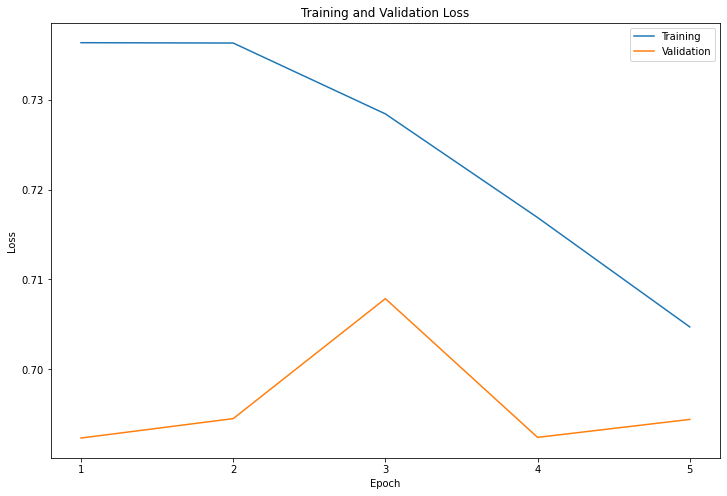

In [70]:
fig, axes = plt.subplots(figsize=(12, 8))
plt.plot(df_stats['Training Loss'], label = 'Training')
plt.plot(df_stats['Validation Loss'], label = 'Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()

This learning curve seems a little bid odd, so my next step will be to inspect the stats and find out why my model outputs these results. 

To be continued...